In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Conv1D
from tensorflow.keras.layers import Conv2D


## ADDING TECHNICAL INDICATORS

In [32]:
# Define a function to calculate technical indicators
def add_technical_indicators(data):
    # Moving Average (MA)
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    data['Short_MA'] = data['Close'].rolling(window=12).mean()
    data['Long_MA'] = data['Close'].rolling(window=26).mean()
    data['MACD'] = data['Short_MA'] - data['Long_MA']

    return data.dropna()

## DATA COLLECTION

In [33]:
data = pd.read_csv('/content/MSFT.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8525 entries, 1986-03-13 to 2020-01-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8525 non-null   float64
 1   High       8525 non-null   float64
 2   Low        8525 non-null   float64
 3   Close      8525 non-null   float64
 4   Adj Close  8525 non-null   float64
 5   Volume     8525 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 466.2 KB


(8525, 6)

In [34]:
data.fillna(method='ffill', inplace=True)

## DEFINE CNN-LSTM MODEL

In [35]:
# Apply feature engineering
data = add_technical_indicators(data)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

sequence_length = 14
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(scaled_data[i, 3])  # Using 'close price' as the target

X, y = np.array(X), np.array(y)

train_size = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn_lstm.add(LSTM(200, return_sequences=True))
model_cnn_lstm.add(LSTM(200))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

## MODEL TRAINING AND PREDICTION

In [36]:
model_cnn_lstm.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)

Epoch 1/50
104/104 [==============================] - 15s 100ms/step - loss: 7.4470e-04
Epoch 2/50
104/104 [==============================] - 10s 101ms/step - loss: 4.8982e-05
Epoch 3/50
104/104 [==============================] - 10s 98ms/step - loss: 4.3156e-05
Epoch 4/50
104/104 [==============================] - 10s 93ms/step - loss: 3.9206e-05
Epoch 5/50
104/104 [==============================] - 11s 106ms/step - loss: 3.6289e-05
Epoch 6/50
104/104 [==============================] - 11s 107ms/step - loss: 3.2646e-05
Epoch 7/50
104/104 [==============================] - 11s 102ms/step - loss: 3.7720e-05
Epoch 8/50
104/104 [==============================] - 10s 101ms/step - loss: 3.3026e-05
Epoch 9/50
104/104 [==============================] - 9s 90ms/step - loss: 2.8212e-05
Epoch 10/50
104/104 [==============================] - 10s 101ms/step - loss: 3.0480e-05
Epoch 11/50
104/104 [==============================] - 10s 100ms/step - loss: 3.1847e-05
Epoch 12/50
104/104 [=============

## MODEL EVALUATION

In [37]:
y_pred_cnn_lstm = scaler.inverse_transform(np.hstack((np.zeros((len(y_pred_cnn_lstm), scaled_data.shape[1] - 1)), y_pred_cnn_lstm)))
y_test = scaler.inverse_transform(np.hstack((np.zeros((len(y_test), scaled_data.shape[1] - 1)), np.expand_dims(y_test, axis=1))))

y_pred_close_cnn_lstm = y_pred_cnn_lstm[:, -1]
y_test_close = y_test[:, -1]

mae_cnn_lstm = mean_absolute_error(y_test_close, y_pred_close_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_close, y_pred_close_cnn_lstm))

print(f"CNN-LSTM Model:")
print(f"Mean Absolute Error: {mae_cnn_lstm}")
print(f"Root Mean Squared Error: {rmse_cnn_lstm}")

CNN-LSTM Model:
Mean Absolute Error: 0.09023937372651883
Root Mean Squared Error: 0.13949498734082544


## VISUALIZATION

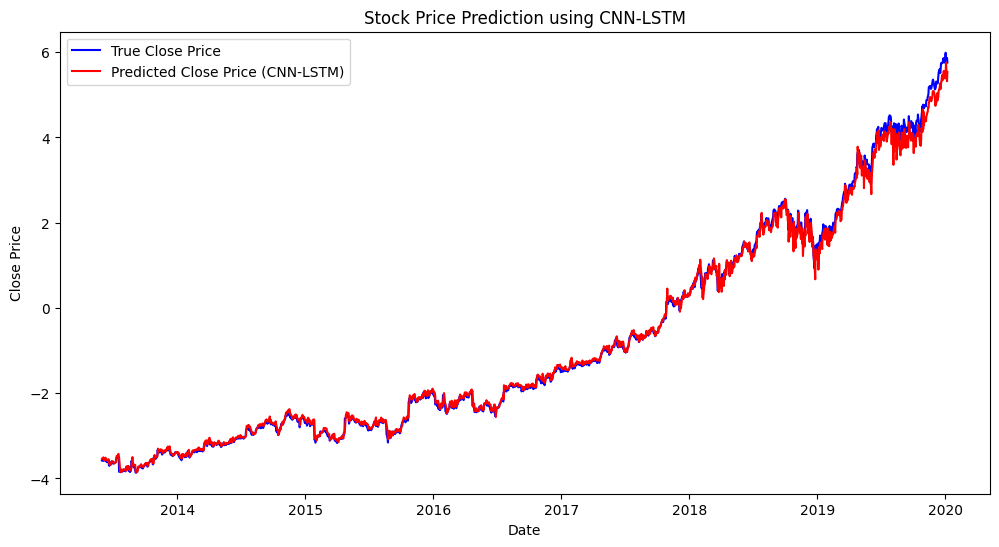

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_close, label='True Close Price', color='blue')
plt.plot(data.index[-len(y_test):], y_pred_close_cnn_lstm, label='Predicted Close Price (CNN-LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction using CNN-LSTM')
plt.legend()
plt.show()